# Create Data Vector

To validate and test the y3 cluster pipeline we make a simplified mock data of the Buzzard v.1.9.8 dataset. Here I build the data vector.

Outline:
- Number counts
- Binned $\gamma_t(\theta)$ profiles
- Power Spectrum (using nbody-tool kit)


In [1]:
#!/usr/bin/env python
import os, fitsio

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table
from scipy.interpolate import interp1d

In [2]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo0 = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
cosmo0 

FlatLambdaCDM(H0=70.0 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)

In [4]:
kw = {'dS':r'$\Delta \Sigma \, \, [M_{\odot}]$',
      'gamma': r'$\left< \gamma_t(\theta) \right>$'}


## Load Mock

For this first validation we will use $\lambda>5$.

For more information how this file was created take a look at the source code.
https://github.com/estevesjh/muStarSigmaProfiles/blob/main/notebooks/0.CreateCopacabanaCatalogs.ipynb

In [5]:
from fileLoc import FileLocs

floc = FileLocs(machine='nersc')
print('halo file name: %s'%floc.mock_fname)

halo file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_v0.fits


In [6]:
data = Table(getdata(floc.mock_fname))
print('All data size: %i'%(len(data)))

All data size: 583043


In [7]:
lgt5 = np.array(data['lambda_mor'])>=5.
lgt20 = np.array(data['lambda_mor'])>=20.

mock = data[lgt5]

print(r'$\lambda>5$ has size: %i'%np.count_nonzero(lgt5))
print(r'$\lambda>20$ has size: %i'%np.count_nonzero(lgt20))

$\lambda>5$ has size: 263624
$\lambda>20$ has size: 11113


# Number Counts

We will try to use the same bining scheme from DES Y1.

$$
\lambda \in [5, 20, 30, 45, 60, \infty] \\
z \in [0.2, 0.35, 0.5, 0.65]
$$

However in the Buzzard simulations the overall number of cluster is less than the DES Y3. So, we might need to change the binning scheme in order to have a reasonable statistics.

In [8]:
from setup_bins import lbdbins, zbins

print('lambda bins:', lbdbins)
print('redshift bins:', zbins)

lambda bins: [  5  10  14  20  30  45  60 130]
redshift bins: [0.2  0.35 0.5  0.65]


In [9]:
zlabels = ['%.2f < z < %.2f'%(zl,zh) for zl, zh in zip(zbins[:-1], zbins[1:])]
zlabels

['0.20 < z < 0.35', '0.35 < z < 0.50', '0.50 < z < 0.65']

In [45]:
kw = {'dS':r'$\Delta \Sigma \, \, [M_{\odot}]$',
      'gamma': r'$\left< \gamma_t(\theta) \right>$',
      'physical':r'$\rm R_p\ [Mpc]$',
      'angle': r'$\theta \; [arcmin]$'
     }

In [11]:
def compute_number_counts(x, z, xbins, zbins):
    counts = []
    for xl, xh in zip(xbins[:-1], xbins[1:]):
        xmask = (x>=xl)&(x<=xh)
        xcounts = []
        for zl, zh in zip(zbins[:-1], zbins[1:]):
            zmask = (z>=zl)&(z<=zh)
            xcounts.append(np.count_nonzero(zmask&xmask))
        counts.append(xcounts)
    return np.array(counts)

In [12]:
lbd = np.array(mock['lambda_mor'])
z = np.array(mock['redshift'])

nc_all_binY3 = compute_number_counts(lbd, z, lbdbins, zbins)

In [13]:
print(nc_all_binY3)

[[ 32000  65258 101135]
 [  6274  11849  17827]
 [  3325   6251   8593]
 [  1614   2760   3613]
 [   555    883   1046]
 [   126    169    168]
 [    58     72     47]]


In [14]:
lb60 = (lbd<lbdbins[-1])&(lbd>=lbdbins[-2])

(array([ 2.,  8., 23., 32., 33., 38., 22.,  8.,  7.,  4.]),
 array([14.5090685, 14.580667 , 14.652265 , 14.723864 , 14.795462 ,
        14.86706  , 14.938658 , 15.010256 , 15.081855 , 15.153453 ,
        15.225051 ], dtype=float32),
 <BarContainer object of 10 artists>)

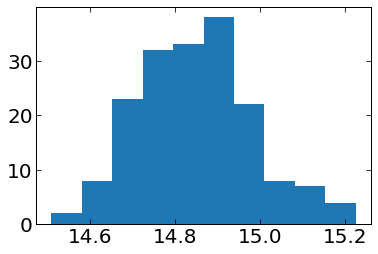

In [15]:
plt.hist(np.log10(mock['Mvir'][lb60]))

The number of clusters on the last lambda bins are very low, specially for the highest one. We should re-define the lambda bins

In [16]:
lbdbins_new = np.array([5, 15, 25, 40, 160])
print('lambda bins:', lbdbins_new)

lambda bins: [  5  15  25  40 160]


(90, 313786.1475953558)

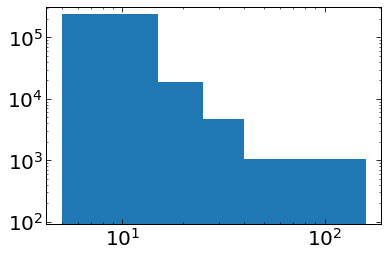

In [17]:
plt.loglog()
plt.hist(lbd, bins=lbdbins_new)
plt.ylim(90,)

In [18]:
lbd = np.array(mock['lambda_mor'])
z = np.array(mock['redshift'])

nc_all_new = compute_number_counts(lbd, z, lbdbins_new, zbins)
print(nc_all_new)

[[ 39099  78704 121209]
 [  3577   6527   8824]
 [  1007   1635   2010]
 [   269    377    387]]


Now we have at least 100 clusters on the highest lambda bins

In [19]:
nc_all_new.flatten()

array([ 39099,  78704, 121209,   3577,   6527,   8824,   1007,   1635,
         2010,    269,    377,    387])

In [46]:
lam_labels = ['%i < $\lambda $ < %i'%(ll,lh) for ll, lh in zip(lbdbins_new[:-1], lbdbins_new[1:])]
lam_labels

['5 < $\\lambda $ < 15',
 '15 < $\\lambda $ < 25',
 '25 < $\\lambda $ < 40',
 '40 < $\\lambda $ < 160']

# $\gamma_t(\theta)$ Profiles

In this section we will convert the physical quantities of the $\Delta \Sigma (R)$ profiles in observed $\gamma_t(\theta)$ profiles. 

The conversion happens in three steps:
- The conversion factor between matter excess and the observed shear profile is $\Sigma^{\prime}_{\rm crit} (z)$.
- The second step is to convert physical units to angular units
- Lastly, we stack the profiles in lambda and redshift bins.

### Boost-Factor 
In this idealized test we don't model Boost-Factor contamination. We will add the model in the next steps of the pipeline.

In [22]:
import radial_bins_phys_mpc as rbp

radii = rbp.rp_phys_mpc
theta = rbp.theta_arcmin

deltaSigma = np.array(mock['DeltaSigma'])
redshift = np.array(mock['redshift'])
lnM = np.log(np.array(mock['Mvir']))
print('Delta Sigma shape:',deltaSigma.shape)

Delta Sigma shape: (263624, 15)


In [23]:
bTable = np.load(floc.mock_boost_factor_1d)
print(list(bTable.keys()))

betaEff = bTable['betaEff']
zEff = bTable['zEff']
zlens = bTable['zlens']


['betaEff', 'zEff', 'zlens', 'Radii']


In [24]:
# G=4.51710305e-48 # Mpc^3 / M_sol / s^2
# c=9.71561189e-15 # Mpc/s

# 4piG/c^2
const = 6.01e-19 # Mpc/M_sol
const*= 1e6 # pc/M_sol

dlens = cosmo0.comoving_distance(zlens).value*1e6 # pc
sigma_crit_vec = const*dlens[:,np.newaxis]*betaEff
sigma_crit_vec_z = sigma_crit_vec[:,-1]

Text(0.5, 1.0, 'Critical Density Amplitude')

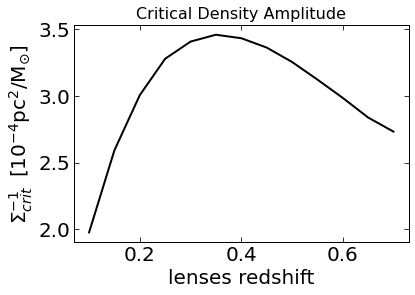

In [25]:
# sigma_crit vs z_lens
plt.plot(zlens, sigma_crit_vec_z*1e4, lw=2, color='k')
plt.xlabel('lenses redshift')
plt.ylabel(r'$\Sigma^{-1}_{crit} \; \; [10^{-4} \rm pc^2/M_{\odot}$]')
plt.title('Critical Density Amplitude',fontsize=16)

### Plot Shear

In [26]:
sigma_crit = np.interp(redshift, zlens, sigma_crit_vec_z)
shear = deltaSigma*sigma_crit[:,np.newaxis]

Text(0.5, 0.98, 'Individual Profiles - Random Draw')

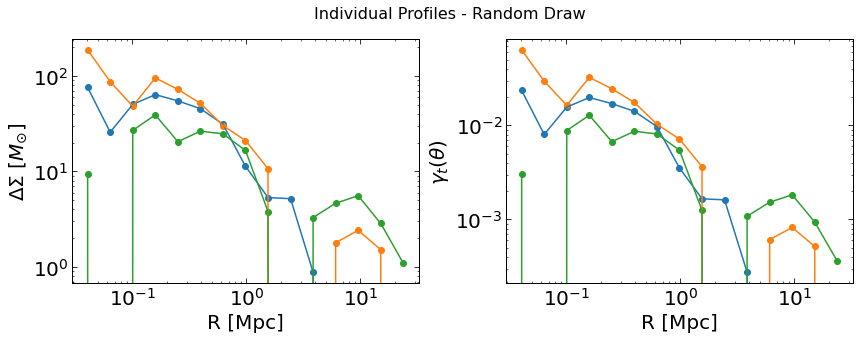

In [27]:
np.random.seed(42)

plt.figure(figsize=(14,4.5))
plt.subplot(1,2,1)
plt.loglog()
randoms = []
for i in range(3):
    ix = np.random.randint(shear.shape[0])
    plt.scatter(radii, deltaSigma[ix])
    plt.plot(radii, deltaSigma[ix])
    randoms.append(ix)
plt.xlabel(r'R [Mpc]')
plt.ylabel(r'$\Delta \Sigma \, \, [M_{\odot}]$')

plt.subplot(1,2,2)
plt.loglog()
for i in range(3):
    ix = randoms[i]
    plt.scatter(radii, shear[ix])
    plt.plot(radii, shear[ix])
plt.xlabel(r'R [Mpc]')
plt.ylabel(r'$\gamma_t(\theta) $')

plt.subplots_adjust(wspace=0.25)
plt.suptitle('Individual Profiles - Random Draw', fontsize=16)


# Stacking Profiles


In [123]:
import stacked_profile_weighted_by_mass_redshift as spw

class StackingProfiles(object):
    def __init__(self, lam_bins, z_bins, method='weighted'):
        print('Stacking Profiles Algorithm')
        self.lam_bins = lam_bins
        self.z_bins = z_bins
        self.method = method
        self.nl = lam_bins.size-1
        self.nz = z_bins.size-1
    
    def load_profiles(self, z, lnM, lam, profile):
        self.z_all = z
        self.alt_rich = lam
        self.lnMvir_all = lnM
        self.profile_all = profile
    
    def run_all_bins(self):
        stack_bins = []
        mean_bins = []
        for lam_min, lam_max in zip(self.lam_bins[:-1], self.lam_bins[1:]):
            print(5*'----')
            print('lam_min, lam_max = %i, %i'%(lam_min, lam_max))
            r1, r2 = [], []
            for zmin, zmax in zip(self.z_bins[:-1], self.z_bins[1:]):
                print('zmin, zmax = %i, %i'%(zmin, zmax))
                # take mean values in a bin weighting by mass and redshift
                prof_sel_mean, prof_sel_stacked = self.stacking_profiles(zmin, zmax,
                                                 lam_min, lam_max)
                r1.append(prof_sel_mean)
                r2.append(prof_sel_stacked)                  

            mean_bins.append(r1)
            stack_bins.append(r2)
        return np.array(mean_bins), np.array(stack_bins)
            
    def stacking_profiles(self, zmin, zmax, lam_min, lam_max, dm = 0.1, dz = 0.05):

        select_obs = (self.alt_rich > lam_min)&(self.alt_rich < lam_max)&(self.z_all>=zmin)&(self.z_all<zmax)

        lnMvir_select = self.lnMvir_all[select_obs]
        z_select = self.z_all[select_obs]
        Sigma_select = self.profile_all[select_obs,:]
        Sigma_select_mean = np.mean(Sigma_select, axis=0)

        if self.method == 'weighted':
            Sigma_stacked = spw.stacked_profile_weighted_by_mass_redshift(lnMvir_select, z_select, Sigma_select, self.lnMvir_all, self.z_all, self.profile_all, dm=dm, dz=dz)

        return Sigma_select_mean, Sigma_stacked

In [124]:
sp = StackingProfiles(lbdbins_new, zbins, method='weighted')
sp.load_profiles(redshift, lnM, lbd, deltaSigma)
print('Delta Sigm')
dS_mean, dS_stack = sp.run_all_bins()
print()
print('Starting Shear Stacking')
sp.load_profiles(redshift, lnM, lbd, shear)
gt_mean, gt_stack = sp.run_all_bins()

Stacking Profiles Algorithm
Delta Sigm
--------------------
lam_min, lam_max = 5, 15
zmin, zmax = 0, 0
zmin, zmax = 0, 0
zmin, zmax = 0, 0
--------------------
lam_min, lam_max = 15, 25
zmin, zmax = 0, 0
zmin, zmax = 0, 0
zmin, zmax = 0, 0
--------------------
lam_min, lam_max = 25, 40
zmin, zmax = 0, 0
zmin, zmax = 0, 0
zmin, zmax = 0, 0
--------------------
lam_min, lam_max = 40, 160
zmin, zmax = 0, 0
zmin, zmax = 0, 0
zmin, zmax = 0, 0

Starting Shear Stacking
--------------------
lam_min, lam_max = 5, 15
zmin, zmax = 0, 0
zmin, zmax = 0, 0
zmin, zmax = 0, 0
--------------------
lam_min, lam_max = 15, 25
zmin, zmax = 0, 0
zmin, zmax = 0, 0
zmin, zmax = 0, 0
--------------------
lam_min, lam_max = 25, 40
zmin, zmax = 0, 0
zmin, zmax = 0, 0
zmin, zmax = 0, 0
--------------------
lam_min, lam_max = 40, 160
zmin, zmax = 0, 0
zmin, zmax = 0, 0
zmin, zmax = 0, 0


In [125]:
def plot_profile(x,px,ax=None,xcol='physical',**kwargs):
    if ax is None: ax = plt.gca()
    ax.loglog()
    ax.plot(x,px,**kwargs)
    ax.set_xlabel(kw[xcol])

Text(0.5, 0.98, 'Stacked Profiles in Physical Units')

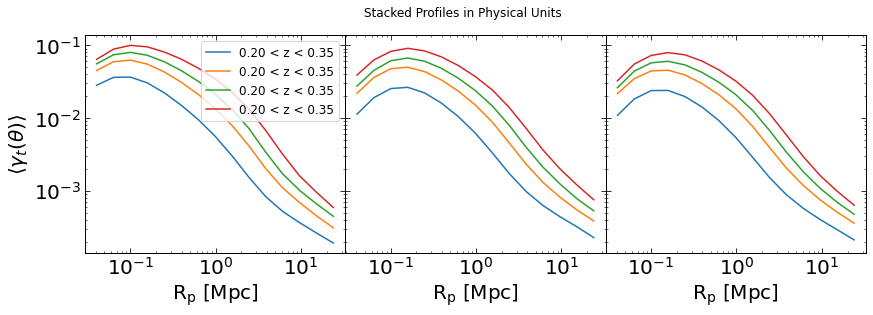

In [126]:
fig, axes = plt.subplots(1, sp.nz, sharex=True, sharey=True, figsize=(sp.nz*4+2, 4), gridspec_kw = {'wspace':0, 'hspace':0})

for i in range(sp.nz):
        ax = axes[i]
        label = None
        for j in range(sp.nl):
            if i==0: label=zlabels[i]
            plot_profile(radii,gt_stack[j][i],ax=ax,label=label)

axes[0].set_ylabel(kw['gamma'])
axes[0].legend(fontsize=12,loc=1)
fig.suptitle('Stacked Profiles in Physical Units')

## Convert from Physical Units to Angle 

We will use arcmin for instance.

In [127]:
from scipy.interpolate import interp1d

# angular conversion factor
rad2deg = 180/np.pi
conv_factor = {"radians": 1.,
               "degrees": 1.*rad2deg, 
               "arcmin" : 60.*rad2deg, 
               "arcsec" : 360.*rad2deg}

# angular distance interpolator
zvec = np.linspace(0., 1.5, 100)
da_interp = interp1d(zvec, cosmo0.angular_diameter_distance(zvec).value)

def theta_converter(r,z):
    # radii or z needs to be a float number 
    theta_vec = r/da_interp(z)
    return theta_vec*conv_factor["arcmin"]

def convert_profile(z, profile):
    theta_vec = theta_converter(radii, z)
    interp_gamma_t = interp1d(theta_vec, profile, bounds_error=False)(theta)
    return interp_gamma_t

In [128]:
gt_mean_theta, gt_stack_theta = [], []
for i in range(sp.nl):
    r1, r2 = [], []
    for j in range(sp.nz):
        zi = (sp.z_bins[j+1]+sp.z_bins[j])/2.
        gt_t = convert_profile( zi , gt_stack[i][j])
        r1.append(gt_t)
    gt_stack_theta.append(r1)

Text(0.5, 0.98, 'Stacked Profiles in Angle Units')

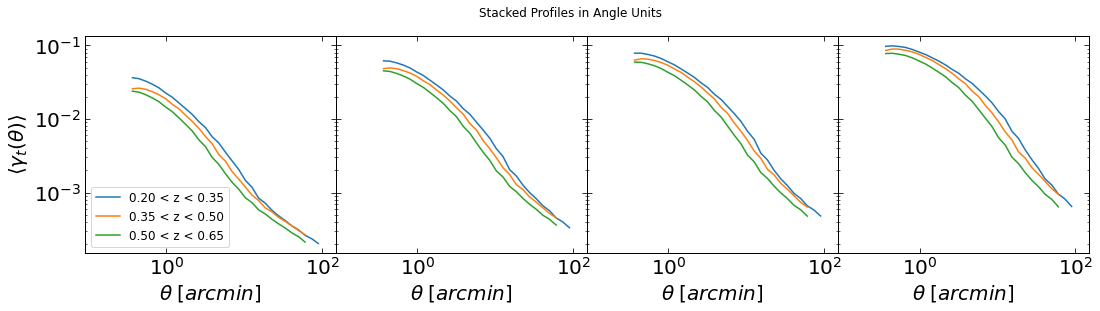

In [129]:
fig, axes = plt.subplots(1, sp.nl, sharex=True, sharey=True, figsize=(sp.nl*4+2, 4), gridspec_kw = {'wspace':0, 'hspace':0})

for i in range(sp.nl):
        ax = axes[i]
        label = None
        for j in range(sp.nz):
            if i==0: label=zlabels[j]
            plot_profile(theta, gt_stack_theta[i][j],ax=ax,xcol='angle',label=label)

axes[0].set_xlim(9e-2, 1.5e2)
axes[0].set_ylabel(kw['gamma'])
axes[0].legend(fontsize=12,loc=3)
fig.suptitle('Stacked Profiles in Angle Units')

Text(0.5, 0.98, 'Stacked Profiles in Physical Units')

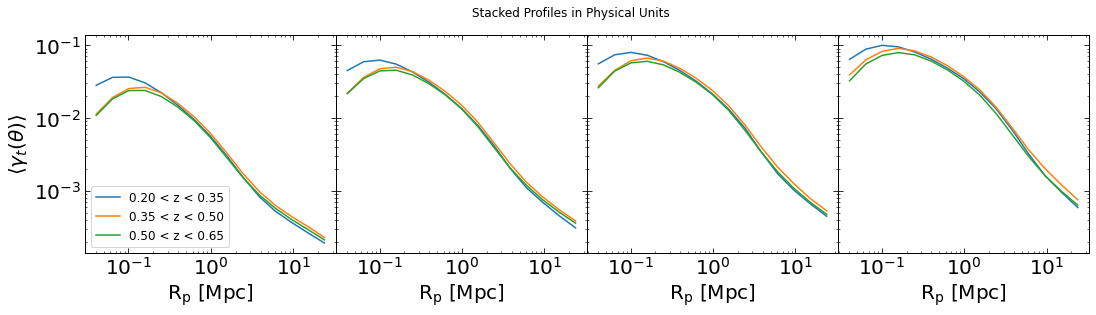

In [130]:
fig, axes = plt.subplots(1, sp.nl, sharex=True, sharey=True, figsize=(sp.nl*4+2, 4), gridspec_kw = {'wspace':0, 'hspace':0})

for i in range(sp.nl):
        ax = axes[i]
        label = None
        for j in range(sp.nz):
            if i==0: label=zlabels[j]
            plot_profile(radii, gt_stack[i][j],ax=ax,label=label)

# axes[0].set_xlim(9e-2, 1.5e2)
axes[0].set_ylabel(kw['gamma'])
axes[0].legend(fontsize=12,loc=3)
fig.suptitle('Stacked Profiles in Physical Units')

### Ilustrating the difference

In [131]:
# we should pay attention to the redshift edges
theta_converter(radii, 0.2)

array([  0.20492402,   0.32318717,   0.50970085,   0.80385294,
         1.26776236,   1.9993973 ,   3.15326413,   4.97303596,
         7.84301143,  12.36927078,  19.50766755,  30.76568539,
        48.52078778,  76.52248982, 120.68417921])

In [132]:
theta_converter(radii, 0.65)

array([ 0.09757297,  0.15388305,  0.24269008,  0.3827483 ,  0.60363515,
        0.95199742,  1.5014021 ,  2.36787224,  3.73438866,  5.88953171,
        9.2884236 , 14.6488409 , 23.10279428, 36.43558609, 57.46282971])

In [133]:
mask = mock['M200']>7e14
randoms = [np.argmin(redshift[mask]), np.argmax(redshift[mask])]

Text(0.5, 0.98, 'Angle Distance Effect - Same Clusters')

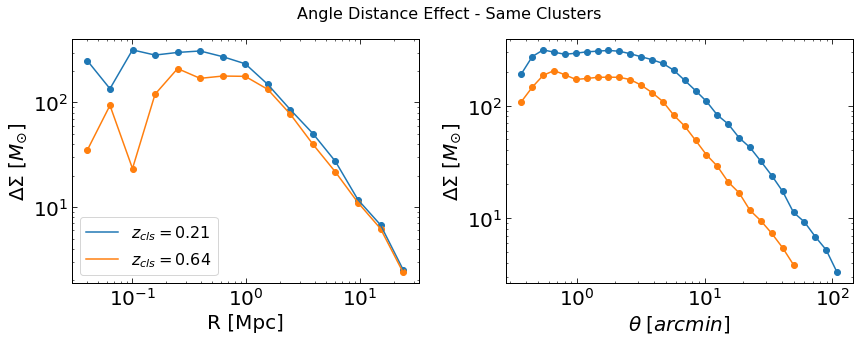

In [134]:
np.random.seed(42)

plt.figure(figsize=(14,4.5))
plt.subplot(1,2,1)
plt.loglog()
for ix in randoms:
    zcls = redshift[mask][ix]
    plt.scatter(radii, deltaSigma[mask][ix])
    plt.plot(radii, deltaSigma[mask][ix],label=r'$z_{cls} = %.2f$'%(zcls))
    
plt.xlabel(r'R [Mpc]')
plt.ylabel(r'$\Delta \Sigma \, \, [M_{\odot}]$')
plt.legend(fontsize=16)
plt.subplot(1,2,2)
plt.loglog()
for ix in randoms:
    zcls = redshift[mask][ix]
    ds = convert_profile(zcls, deltaSigma[mask][ix]) 
    plt.scatter(theta, ds)
    plt.plot(theta, ds,label=r'$z_{cls} = %.2f$'%(zcls))


plt.xlabel(r'$\theta \; [arcmin]$')
plt.ylabel(r'$\Delta \Sigma \, \, [M_{\odot}]$')

plt.subplots_adjust(wspace=0.25)
plt.suptitle(r'Angle Distance Effect - Same Clusters', fontsize=16)


## Write Data Block

We already have the binned number counts and shear profiles. Now I should compute the cluster power spectrum. But before adding the third datavector, I will save the current progress.

In [135]:
import h5py

In [158]:
# fname = floc.dataVector_fname

# with h5py.File(fname, "w") as f:
#     f.create_group("NC")
#     vec = nc_all_new.flatten()
#     f["NC"].create_dataset("vec", data=vec,dtype='i')
    
#     f.create_group("GT")
#     vec = np.array(gt_stack_theta).flatten()
#     f["GT"].create_dataset("GT/vec", data=vec)